# Basketball Win Prediction: Models with filtered Mutual-Information features

The notebook evaluates 8 different model types across the Mutual-Information feature set(features selected taken variable dependence into account):
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient Boosting
- LightGBM
- KMeans Clustering
- Neural Networks(PyTorch)

In [34]:
# Import all required packages for modeling, evaluation, preprocessing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from scipy.stats import mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
# Create output directory
output_dir = Path("model_results/mutual-info")
output_dir.mkdir(exist_ok=True, parents=True)
figures_dir = Path("figures/model_results/mutual-info")
figures_dir.mkdir(exist_ok=True, parents=True)

## Load and prepare dataset
We start by loading the dataset containing engineered features and defining the target and feature matrix. Leakage columns are removed.

In [35]:
data_path = Path("engineered_data/engineered_final_feature_dataset.csv")
df = pd.read_csv(data_path)
X_full = df.drop(columns=["HOME_TEAM_WINS", "GAME_ID", "SEASON", "HOME_TEAM_ID", "VISITOR_TEAM_ID"])
print(X_full.columns)
y = df["HOME_TEAM_WINS"]
print(f"Loaded data with shape: {df.shape}")

Index(['GAME_DATE_EST', 'TEAM_ID_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'GAME_INDEX',
       'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT', 'HOME_LAST_N_AVG_PTS',
       'AWAY_LAST_N_AVG_PTS', 'HOME_LAST_N_AVG_PTS_ALLOWED',
       'AWAY_LAST_N_AVG_PTS_ALLOWED', 'TEAM_NAME_HOME', 'TOTAL_GAMES_HOME',
       'WINS_HOME', 'LOSSES_HOME', 'WIN_PCT_HOME', 'HOME_WINS_HOME',
       'HOME_LOSSES_HOME', 'AWAY_WINS_HOME', 'AWAY_LOSSES_HOME',
       'AVG_PTS_SCORED_HOME', 'AVG_PTS_CONCEDED_HOME', 'AVG_FG_PCT_HOME',
       'MAX_WIN_STREAK_HOME', 'MAX_LOSS_STREAK_HOME', 'TEAM_NAME_AWAY',
       'TOTAL_GAMES_AWAY', 'WINS_AWAY', 'LOSSES_AWAY', 'WIN_PCT_AWAY',
       'HOME_WINS_AWAY', 'HOME_LOSSES_AWAY', 'AWAY_WINS_AWAY',
       'AWAY_LOSSES_AWAY', 'AVG_PTS_SCORED_AWAY', 'AVG_PTS_CONCEDED_AWAY',
       'AVG_FG_PCT_AWAY', 'MAX_WIN_STREAK_AWAY', 'MAX_LOSS_STREAK_AWAY',
 

## Feature scaling
Mutual info filtered features are scaled for use in models that require standardization.

In [36]:
# Load feature sets
feature_sets_path = Path("selected_features/feature_sets.pkl")
with open(feature_sets_path, "rb") as f:
    feature_sets = pickle.load(f)

mutual_info = feature_sets['mutual_info_filtered']

In [37]:
# Safely drop leakage columns that exist
leakage_columns = ['POINT_DIFF', 'ABS_POINT_DIFF', 'GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']
leakage_columns = [col for col in leakage_columns if col in df.columns]

X_full = df.drop(columns=leakage_columns + ['HOME_TEAM_WINS'])
y = df['HOME_TEAM_WINS']

print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Target distribution: {1.0: 0.5885332719318443, 0.0: 0.41146672806815565}


In [38]:
# Select mutual information features
selected_features = feature_sets['mutual_info_filtered']
X = X_full[selected_features]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imputation and Scaling
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=selected_features)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

## Define and configure models
We define all ML models, specifying whether they require scaling.

In [39]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05,
                                 use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1)
}

In [40]:
results = []
model_preds = {}
# Loop through each model and train it
# Collect performance metrics: accuracy, F1, AUC
for name, model in models.items():
    print(f"Training {name}...")

    X_train_input = X_train_scaled if name == "Logistic Regression" else X_train
    X_test_input = X_test_scaled if name == "Logistic Regression" else X_test
    model_preds[name] = {
    "y_true": y_test,
    "probas": probas
    }

    start = time.time()
    model.fit(X_train_input, y_train)
    duration = time.time() - start

    preds = model.predict(X_test_input)
    probas = model.predict_proba(X_test_input)[:, 1]

    results.append({
        "model_name": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_score": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probas),
        "train_time": duration
    })


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training LightGBM...


In [41]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [42]:
# First dense layer with ReLU + BatchNorm + Dropout
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.dropout_input = nn.Dropout(0.1)

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout_input(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output(x))

model = AdvancedNet(input_dim=X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [43]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 40

# Train
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f}")
training_time = time.time() - start_time


Epoch 1/40 | Loss: 128.7252
Epoch 2/40 | Loss: 123.6875
Epoch 3/40 | Loss: 121.9666
Epoch 4/40 | Loss: 122.0535
Epoch 5/40 | Loss: 121.6162
Epoch 6/40 | Loss: 121.2267
Epoch 7/40 | Loss: 120.5964
Epoch 8/40 | Loss: 120.5818
Epoch 9/40 | Loss: 120.3092
Epoch 10/40 | Loss: 120.9655
Epoch 11/40 | Loss: 120.1968
Epoch 12/40 | Loss: 121.0146
Epoch 13/40 | Loss: 119.3706
Epoch 14/40 | Loss: 119.4658
Epoch 15/40 | Loss: 120.6323
Epoch 16/40 | Loss: 119.9087
Epoch 17/40 | Loss: 119.9524
Epoch 18/40 | Loss: 119.5394
Epoch 19/40 | Loss: 119.2897
Epoch 20/40 | Loss: 119.3095
Epoch 21/40 | Loss: 119.3705
Epoch 22/40 | Loss: 119.0726
Epoch 23/40 | Loss: 119.7857
Epoch 24/40 | Loss: 118.9725
Epoch 25/40 | Loss: 119.1328
Epoch 26/40 | Loss: 119.7132
Epoch 27/40 | Loss: 119.0354
Epoch 28/40 | Loss: 120.0613
Epoch 29/40 | Loss: 119.5418
Epoch 30/40 | Loss: 119.8604
Epoch 31/40 | Loss: 118.8683
Epoch 32/40 | Loss: 119.0371
Epoch 33/40 | Loss: 119.7849
Epoch 34/40 | Loss: 119.5680
Epoch 35/40 | Loss: 117

In [44]:
# Evaluate PyTorch model on test data
model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).numpy().flatten()
    y_preds = (y_probs >= 0.5).astype(int)
    model_preds["Neural Network (PyTorch)"] = {
    "y_true": y_test.values,
    "probas": y_probs
    }

print("PyTorch Neural Network (Mutual Info Features):")
print("Accuracy:", accuracy_score(y_test, y_preds))
print("F1 Score:", f1_score(y_test, y_preds))
print("AUC:", roc_auc_score(y_test, y_probs))

# Save to all_results
nn_result = {
    "model_name": "Neural Network (PyTorch)",
    "feature_set": "mutual_info_filtered",
    "accuracy": accuracy_score(y_test, y_preds),
    "f1_score": f1_score(y_test, y_preds),
    "auc": roc_auc_score(y_test, y_probs),
    "train_time": training_time,
}

results.append(nn_result)

PyTorch Neural Network (Mutual Info Features):
Accuracy: 0.8332693783576363
F1 Score: 0.858353708231459
AUC: 0.9169550588526787


## KMeans Clustering Baseline
This is a clustering model for unsupervised learning. We align cluster labels using majority voting to match the target labels.

In [45]:
def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=True)[0]
    return labels

start = time.time()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_preds = kmeans.predict(X_test_scaled)
aligned_preds = align_clusters(y_test.values, kmeans_preds)
train_time = time.time() - start

kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': accuracy_score(y_test, aligned_preds),
    'f1_score': f1_score(y_test, aligned_preds),
    'auc': roc_auc_score(y_test, aligned_preds),
    'train_time': train_time,
}

results.append(kmeans_result)

## Evaluation Results (Initial)
We display the performance of each model trained using the mutual info feature set.

In [46]:
results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
results_df.to_csv(output_dir / "mutual_info_results.csv", index=False)
results_df[['model_name', 'accuracy', 'f1_score', 'auc', 'train_time']].sort_values(
    by='f1_score', ascending=False
).reset_index(drop=True)

,model_name,accuracy,f1_score,auc,train_time
0,Logistic Regression,0.834229,0.860285,0.917663,0.258819
1,Neural Network (PyTorch),0.833269,0.858354,0.916955,52.651632
2,LightGBM,0.830583,0.857328,0.914451,0.320567
3,XGBoost,0.830200,0.856819,0.913515,2.632489
4,Gradient Boosting,0.830200,0.856773,0.914061,53.924293
5,Random Forest,0.825211,0.853041,0.909892,15.686106
6,Decision Tree,0.792210,0.823472,0.838343,0.407848
7,KMeans Clustering,0.631619,0.630200,0.652724,0.106520


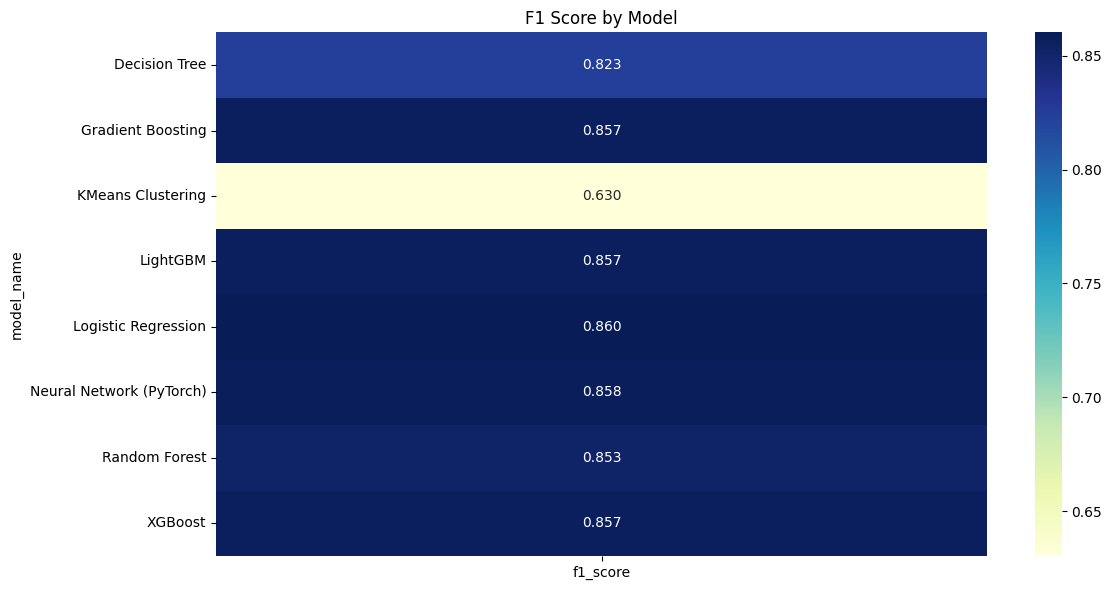

In [47]:
pivot_f1 = results_df.pivot_table(
    index='model_name', 
    values='f1_score'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1 Score by Model")
plt.tight_layout()
plt.show()

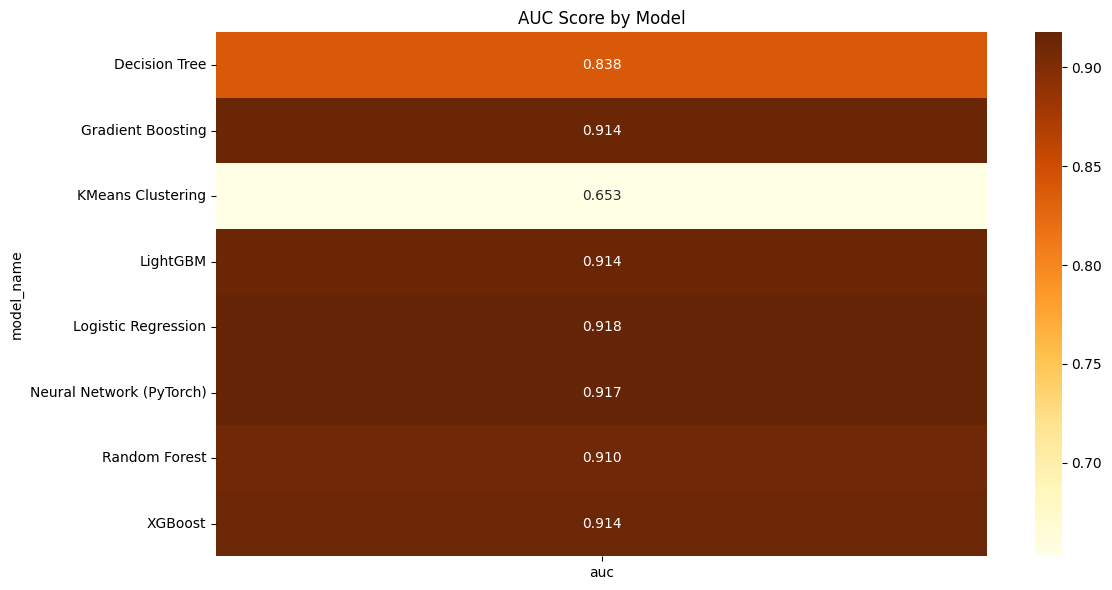

In [48]:
pivot_auc = results_df.pivot_table(
    index='model_name', 
    values='auc'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("AUC Score by Model")
plt.tight_layout()
plt.show()


## Cross Validation (Sklearn Models)
We now evaluate models using 5-fold Stratified Cross-Validation.


In [49]:
# Evaluate accuracy, F1, and AUC for each model using cross_validate
def evaluate_model_cv(model, X, y, name, scale=False):
    if scale:
        X = StandardScaler().fit_transform(X)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, scoring=['accuracy', 'f1', 'roc_auc'], cv=cv)
    return {
        'model_name': name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1'])
    }

In [50]:
results_cv = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    result = evaluate_model_cv(model, X, y, name)
    results_cv.append(result)

Running CV for: Logistic Regression
Running CV for: Decision Tree
Running CV for: Random Forest
Running CV for: XGBoost
Running CV for: Gradient Boosting
Running CV for: LightGBM


## PyTorch Neural Net + KMeans Clustering: Cross Validation
We train a new neural network per fold, and collect performance metrics, and label alignment is performed for each fold as well.

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KMeans Clustering CV Evaluation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        # Get scalar mode value only
        majority_label = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = majority_label
    return labels

kmeans_metrics = {'accuracy': [], 'f1_score': [], 'auc': []}

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    kmeans.fit(X_train_fold)
    preds = kmeans.predict(X_test_fold)
    aligned_preds = align_clusters(y_test_fold, preds)

    kmeans_metrics['accuracy'].append(accuracy_score(y_test_fold, aligned_preds))
    kmeans_metrics['f1_score'].append(f1_score(y_test_fold, aligned_preds))
    kmeans_metrics['auc'].append(roc_auc_score(y_test_fold, aligned_preds))

print("\nKMeans Clustering Cross-Validation:")
print(f"Accuracy: {np.mean(kmeans_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(kmeans_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(kmeans_metrics['auc']):.4f}")

# Neural Network CV (PyTorch)

for train_idx, test_idx in cv.split(X_scaled, y):
    # Prepare tensors
    X_train_fold = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y.values[train_idx], dtype=torch.float32).view(-1, 1)
    X_test_fold = torch.tensor(X_scaled[test_idx], dtype=torch.float32)
    y_test_fold = torch.tensor(y.values[test_idx], dtype=torch.float32).view(-1, 1)

    # Dataloader for mini-batch training
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Model
    model = AdvancedNet(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Optional: learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    for epoch in range(30):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test_fold).numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        y_true = y_test_fold.numpy().flatten()

        nn_metrics['accuracy'].append(accuracy_score(y_true, preds))
        nn_metrics['f1_score'].append(f1_score(y_true, preds))
        nn_metrics['auc'].append(roc_auc_score(y_true, probs))

# Final CV results
print("\nNeural Network (AdvancedNet) Cross-Validation:")
print(f"Accuracy: {np.mean(nn_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(nn_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(nn_metrics['auc']):.4f}")


KMeans Clustering Cross-Validation:
Accuracy: 0.6377
F1 Score: 0.6394
AUC: 0.6575

Neural Network (AdvancedNet) Cross-Validation:
Accuracy: 0.8155
F1 Score: 0.8497
AUC: 0.8982


## Cross-Validation Heatmaps
Heatmaps provide a quick overview of model performance across F1 and AUC.


In [52]:
traditional_df = pd.DataFrame(results_cv)

# KMeans results
kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': np.mean(kmeans_metrics['accuracy']),
    'f1_score': np.mean(kmeans_metrics['f1_score']),
    'auc': np.mean(kmeans_metrics['auc']),
    'cv_std': np.std(kmeans_metrics['f1_score'])
}

# PyTorch NN results
nn_result = {
    'model_name': 'Neural Network (PyTorch)',
    'accuracy': np.mean(nn_metrics['accuracy']),
    'f1_score': np.mean(nn_metrics['f1_score']),
    'auc': np.mean(nn_metrics['auc']),
    'cv_std': np.std(nn_metrics['f1_score'])
}

# Combine all results
all_cv_results = pd.concat([traditional_df, pd.DataFrame([kmeans_result, nn_result])], ignore_index=True)

# Sort by F1 Score
all_cv_results = all_cv_results.sort_values(by='f1_score', ascending=False)

# Display table
print(all_cv_results[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std']]) 

                 model_name  accuracy  f1_score       auc    cv_std
0       Logistic Regression  0.835521  0.861903  0.918810  0.002850
3                   XGBoost  0.833832  0.860103  0.916214  0.002945
5                  LightGBM  0.833602  0.859726  0.916875  0.001849
4         Gradient Boosting  0.832451  0.858827  0.915523  0.002227
2             Random Forest  0.829342  0.856587  0.911261  0.003277
7  Neural Network (PyTorch)  0.815469  0.849702  0.898233  0.013688
1             Decision Tree  0.791273  0.822830  0.833389  0.003696
6         KMeans Clustering  0.637731  0.639368  0.657531  0.007856


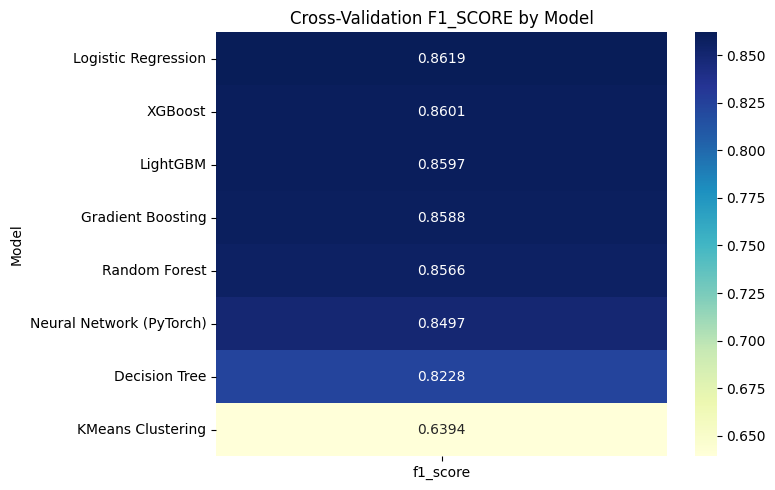

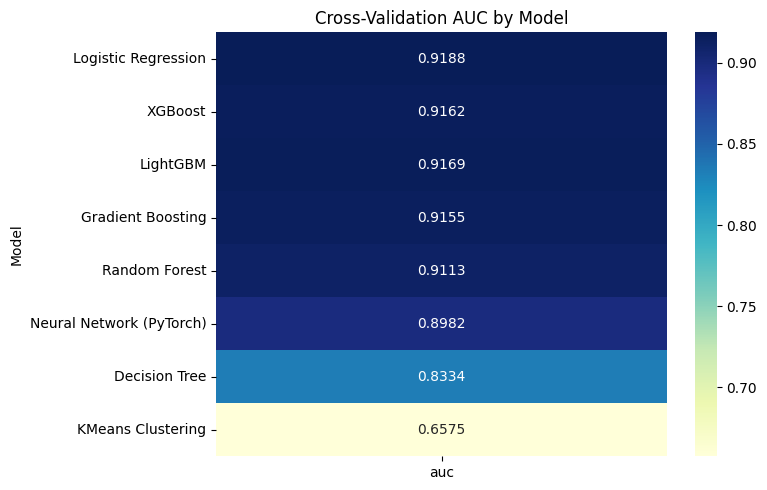

In [53]:
metrics_to_plot = ['f1_score', 'auc']

for metric in metrics_to_plot:
    pivot_df = all_cv_results[['model_name', metric]].set_index('model_name')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", cbar=True)
    plt.title(f"Cross-Validation {metric.upper()} by Model")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

## HyperParameter Tuning
To push model performance, we perform GridSearchCV with cross-validation to find the best params for each model, with tuning being done with F1 as scoring.

In [54]:
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'verbose': [-1]
        }
    }
}

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_results = []

for name, cfg in param_grids.items():
    print(f"\nRunning GridSearchCV for: {name}")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    scores = grid.cv_results_

    tuned_results.append({
        'model_name': name,
        'best_params': grid.best_params_,
        'mean_accuracy': np.mean(scores['mean_test_score']),
        'best_score': grid.best_score_
    })

tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values(by='best_score', ascending=False)


Running GridSearchCV for: Logistic Regression

Running GridSearchCV for: Random Forest

Running GridSearchCV for: Gradient Boosting

Running GridSearchCV for: XGBoost

Running GridSearchCV for: LightGBM


In [56]:
print(tuned_df[['model_name', 'best_params', 'best_score']])

            model_name                                        best_params  \
0  Logistic Regression       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}   
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
3              XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
4             LightGBM  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
1        Random Forest  {'max_depth': 20, 'min_samples_split': 5, 'n_e...   

   best_score  
0    0.862864  
2    0.861523  
3    0.861213  
4    0.860725  
1    0.856753  


In [57]:
final_tuned_cv_results = []

for _, row in tuned_df.iterrows():
    model_name = row['model_name']
    params = row['best_params']

    if model_name == 'Logistic Regression':
        model = LogisticRegression(**params, max_iter=1000)
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(**params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(**params)
    else:
        continue  # Skip unsupported models

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=['accuracy', 'f1', 'roc_auc'])

    final_tuned_cv_results.append({
        'model_name': model_name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1']),
        'best_params': params
    })

final_cv_df = pd.DataFrame(final_tuned_cv_results).sort_values(by='f1_score', ascending=False)

## Summary of Tuned Results
This section displays the best hyperparameters and model scores after tuning.

In [58]:
print(final_cv_df[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std', 'best_params']])

            model_name  accuracy  f1_score       auc    cv_std  \
0  Logistic Regression  0.835521  0.861903  0.918810  0.002850   
1    Gradient Boosting  0.835444  0.861523  0.918126  0.001629   
2              XGBoost  0.835214  0.861213  0.918456  0.002903   
3             LightGBM  0.834523  0.860725  0.918082  0.002162   
4        Random Forest  0.829227  0.856543  0.911525  0.003364   

                                         best_params  
0       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}  
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
4  {'max_depth': 20, 'min_samples_split': 5, 'n_e...  


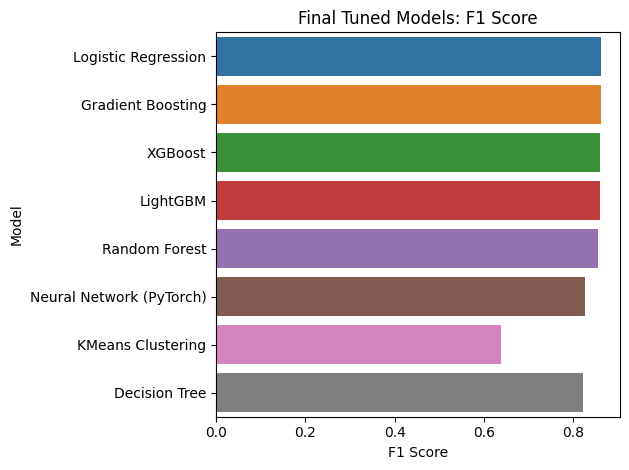

In [61]:
final_cv_df = pd.DataFrame(final_tuned_cv_results)
final_cv_df = pd.concat([
    final_cv_df,
    pd.DataFrame([
        {
            'model_name': 'Neural Network (PyTorch)',
            'accuracy': 0.794805, 
            'f1_score': 0.8272,
            'auc': 0.8787,
            'cv_std': 0.017277,
            'best_params': 'AdvancedNet (custom)'
        },
        {
            'model_name': 'KMeans Clustering',
            'accuracy': 0.637731,
            'f1_score': 0.639368,
            'auc': 0.657531,
            'cv_std': 0.007856,
            'best_params': 'n_clusters=2'
        },
        {
            "model_name": "Decision Tree",
            "accuracy": 0.791273,
            "f1_score": 0.822830,
            "auc": 0.833389,
            "cv_std": 0.003696,
            "best_params": "n/a"
        }
    ])
], ignore_index=True)

sns.barplot(data=final_cv_df, x='f1_score', y='model_name')
plt.title('Final Tuned Models: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [62]:
# Load final cross-validation + hyperparameter tuned results to csv
final_cv_df.to_csv("results/final_cv_mutual_info.csv", index=False)

## Final Summary & Key Takeaways (mutual_info_filtered Feature Set)

In this notebook, we evaluated a diverse suite of models using the `mutual_info_filtered` feature set — a compact subset of the top 30 features ranked by their mutual information with the target. This ensures a **fair, non-model-specific** approach to feature selection and avoids overfitting through bias from model-based filters.

### Models Implemented:
- **Traditional Machine Learning**:  
  - Logistic Regression  
  - Random Forest  
  - Decision Tree  
  - Gradient Boosting  
  - LightGBM  
  - XGBoost

- **Unsupervised Model**:  
  - KMeans Clustering (aligned via majority voting)

- **Deep Learning**:  
  - PyTorch Neural Network (AdvancedNet with batch normalization, dropout, and scheduler)

---

### Evaluation Process:
1. **Training** all models on a consistent mutual_info_filtered subset.
2. **Cross-validation** (Stratified 5-Fold) for robust performance estimation.
3. **Hyperparameter tuning** using GridSearchCV (for all ML models).
4. **Final performance aggregation** including: F1 Score, AUC, Accuracy, and Standard Deviation.

---

### Key Insights:
- **Logistic Regression achieved the highest F1 score and AUC**, even outperforming complex models after tuning.  
  This suggests that:
  - The mutual_info_filtered feature set may be **well-aligned with linear decision boundaries**.
  - Many of the top mutual information features (e.g. `shooting_edge`, `FG_PCT_home`, `AST_REB_ratio_home`) already **linearly separate** the classes effectively.
  - Complex models like XGBoost and Neural Networks may have had **limited opportunity to leverage nonlinearity** in this reduced feature space.

- **Gradient Boosting and XGBoost came close**, with strong scores and stability across folds — they benefit from handling weak interactions, but were marginally behind LR.

- **The Pytorch Neural Network model** had competitive metrics, only slightly underperforming logistic regression, especially considering the limited number of features — highlighting that a deep model can still extract meaningful representations even from compact data.

- **KMeans Clustering** showed expectedly lower performance. As an unsupervised approach, it struggles in high-dimensional, non-separable feature spaces where no label signal is leveraged during training.

---

### Next Steps:
- Re-run this modeling pipeline using the `anova_top_30` and `pca_transformed` feature sets to compare consistency.
- Investigate whether regularization or feature interactions help boost non-linear models on these alternate subsets.
- Use the most promising model(s) to evaluate deployment-readiness or further interpretability analysis.

---
